# Тестовое задание

В данном задании необходимо написать код, который считает следующие признаки для каждого клиента `user_id`:

1. `events_ordinal_number` - порядковый номер события
2. `second_event_time` - время второго события
2.	`loan_ordinal_number` - порядковый номер займа
2.	`events_time_diff` - разница во времени между событиями
2.	`previous_loans_max_amount` - максимальная сумма предыдущего займа.


### Подготовка датафрейма

In [83]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
df = pd.read_csv('test_Feb22.csv')

In [85]:
df[df['user_id'] == 116].head()

,Unnamed: 0,time,user_id,type,amount,target,feature1,feature2,events_ordinal_number,second_event_time,loan_ordinal_number,events_time_diff,previous_loans_max_amount
597,597,2001-01-25 21:00:00,116,loanRequest,14358,NaN,1,1,1,2001-02-28 07:00:00,1,NaN,NaN
1399,1399,2001-02-28 07:00:00,116,loanRequest,15363,NaN,1,0,2,2001-02-28 07:00:00,1,33 days 10:00:00,NaN
1868,1868,2001-03-19 20:00:00,116,loanRequest,16106,NaN,1,0,3,2001-02-28 07:00:00,1,19 days 13:00:00,NaN
2189,2189,2001-04-02 05:00:00,116,loanRequest,15613,NaN,0,1,4,2001-02-28 07:00:00,1,13 days 09:00:00,NaN
3806,3806,2001-06-08 14:00:00,116,loan,13689,0.0,0,0,5,2001-02-28 07:00:00,1,67 days 09:00:00,NaN


In [86]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 10000 non-null  int64  
 1   time                       10000 non-null  object 
 2   user_id                    10000 non-null  int64  
 3   type                       10000 non-null  object 
 4   amount                     10000 non-null  int64  
 5   target                     2019 non-null   float64
 6   feature1                   10000 non-null  int64  
 7   feature2                   10000 non-null  int64  
 8   events_ordinal_number      10000 non-null  int64  
 9   second_event_time          9999 non-null   object 
 10  loan_ordinal_number        10000 non-null  int64  
 11  events_time_diff           9000 non-null   object 
 12  previous_loans_max_amount  5642 non-null   float64
dtypes: float64(2), int64(7), object(4)
memory usage

### Оценим важность признаков f1 и f2


Часто наборы данных, с которыми приходится работать, содержат большое количество признаков, число которых может достигать нескольких сотен и даже тысяч. При построении модели машинного обучения не всегда понятно, какие из признаков действительно для неё важны (т.е. имеют связь с целевой переменной), а какие являются избыточными (или шумовыми). Удаление избыточных признаков позволяет лучше понять данные, а также сократить время настройки модели, улучшить её точность и облегчить интерпретируемость.

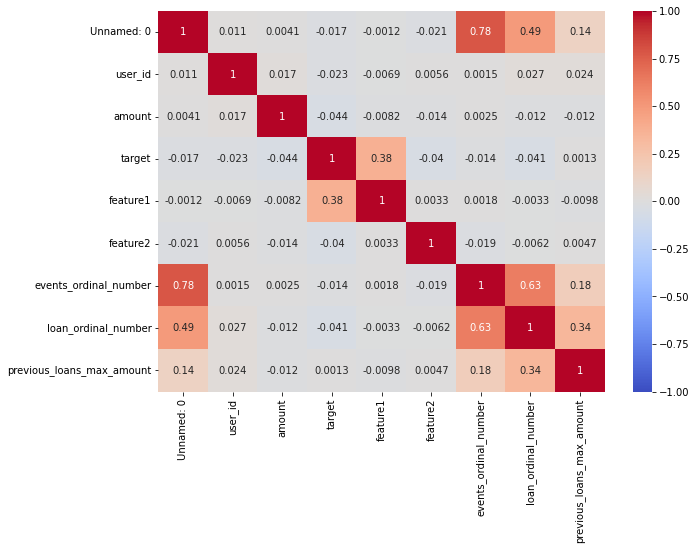

In [87]:
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(1,1,1)
sns.heatmap(df.corr(), cmap = sns.color_palette('coolwarm', 10000), vmin = -1, center = 0, annot = True)
plt.show()

Как видно из матрицы, корреляция между признаком feature 1 и target равна 0.38, а между feature 2 и target - -0.04. Из этого следует, что признак feature 1 болеее значим для модели, чем признак feature 2.

### Расчет признаков

#### Признак `events_ordinal_number`

In [88]:
# весь код расчета признака должен быть в этом методе
def calculate_events_number(data):
  data = data.sort_values(['user_id','time'])
  list_of_numbers = [1]                                   
  number = 2  
  for i in range(1, len(data['user_id'])):
    if data.iloc[i]['user_id'] == data.iloc[i-1]['user_id']:   
      list_of_numbers.append(number)                        
      number += 1                                          
    else:
      list_of_numbers.append(1)                            
      number = 2
  data['events_number_my'] = list_of_numbers
  return data

In [89]:
df = calculate_events_number(df)
df[['events_ordinal_number','events_number_my']]

,events_ordinal_number,events_number_my
186,1,1
373,2,2
481,3,3
602,4,4
1229,5,5
...,...,...
3525,5,5
6342,6,6
6474,7,7
6925,8,8


In [90]:
# list_of_numbers_1 = []   # у самого первого элемента датафрейма порядковый номер равен 1
# number = 1  
# for i in range(0, len(df['user_id']) - 1):
#   if df.iloc[i]['user_id'] == df.iloc[i+1]['user_id']:   # если user_id двух ближайших элементов совпадают
#     list_of_numbers_1.append(number)                       # то добавляем в список порядковый номер 
#     number += 1                                          # увеличиваем порядковый номер для следующего элемента
#   else:
#     list_of_numbers_1.append(number)                            # если user_id двух соседних элементов не совпадают, то начинаем отсчет сначала - первому элементу с другим user_id присваиваем 1
#     number = 1

#### Признак `second_event_time`

In [91]:
# весь код расчета признака должен быть в этом методе
def calculate_second_event_time(data):
  data = data.sort_values(['user_id','time'])
  second_event_time_my = []
  for i in range(len(data['user_id'])):
    if len(data[data['user_id'] == data.iloc[i]['user_id']]) > 1:
      second_event_time_my.append(data[((data['user_id'] == data.iloc[i]['user_id']) & (data['events_number_my'] == 2))]['time'].values[0])
    else:
      second_event_time_my.append(None)
  data['second_event_time_my'] = second_event_time_my
  return data

In [92]:
df = calculate_second_event_time(df)
df[['second_event_time_my','second_event_time']]

,second_event_time_my,second_event_time
186,2001-01-16 13:00:00,2001-01-16 13:00:00
373,2001-01-16 13:00:00,2001-01-16 13:00:00
481,2001-01-16 13:00:00,2001-01-16 13:00:00
602,2001-01-16 13:00:00,2001-01-16 13:00:00
1229,2001-01-16 13:00:00,2001-01-16 13:00:00
...,...,...
3525,2001-03-14 11:00:00,2001-03-14 11:00:00
6342,2001-03-14 11:00:00,2001-03-14 11:00:00
6474,2001-03-14 11:00:00,2001-03-14 11:00:00
6925,2001-03-14 11:00:00,2001-03-14 11:00:00


In [93]:
# for i in df['user_id'].value_counts().index.sort_values():
#   if df['user_id'].value_counts()[i] > 1:
#     df[df['user_id'] == i]['2nd_event_time'] = df[(df['events_number_my'] == 2) & (df['user_id'] == df.iloc[i]['user_id'])]['time'].values[0]

#### Признак `loan_ordinal_number`

In [94]:
# весь код расчета признака должен быть в этом методе
def calculate_loan_number(data):
  data = data.sort_values(['user_id','time'])
  loan_number_list = []
  number = 1
  for i in range(len(data['user_id'])):
    if i == 0:
      loan_number_list.append(number)
      if data.iloc[i]['type'] == 'loan':
        number += 1
    elif data.iloc[i]['user_id'] == data.iloc[i-1]['user_id']:
      if data.iloc[i]['type'] == 'loan':
        loan_number_list.append(number)
        number += 1
      else:
        loan_number_list.append(number)
    else:
      number = 1
      loan_number_list.append(number)
  data['loan_number_my'] = loan_number_list
  return data

In [95]:
df = calculate_loan_number(df)
df[['loan_number_my','loan_ordinal_number']]

,loan_number_my,loan_ordinal_number
186,1,1
373,2,2
481,2,2
602,2,2
1229,2,2
...,...,...
3525,2,2
6342,3,3
6474,3,3
6925,3,3


#### Признак `events_time_diff`

In [96]:
# весь код расчета признака должен быть в этом методе
def calculate_time_diff(data):
  data[['time','second_event_time_my']] = data[['time','second_event_time_my']].apply(pd.to_datetime)
  diff_list = []
  for i in range(len(data['user_id'])):
    if data.iloc[i]['events_number_my'] == 1:
      diff_list.append(None)
    else:
      differ = data.iloc[i]['time'] - data[(data['user_id'] == data.iloc[i]['user_id']) & (data['events_number_my'] == data.iloc[i]['events_number_my'] - 1)]['time'].values[0]
      diff_list.append(differ)

  data['time_difference'] = diff_list
  return data

In [97]:
df = calculate_time_diff(df)
df[['events_time_diff','time_difference']]

,events_time_diff,time_difference
186,NaN,NaT
373,7 days 19:00:00,7 days 19:00:00
481,4 days 12:00:00,4 days 12:00:00
602,5 days 01:00:00,5 days 01:00:00
1229,26 days 03:00:00,26 days 03:00:00
...,...,...
3525,31 days 22:00:00,31 days 22:00:00
6342,117 days 09:00:00,117 days 09:00:00
6474,5 days 12:00:00,5 days 12:00:00
6925,18 days 19:00:00,18 days 19:00:00


#### Признак `previous_loans_max_amount`

In [98]:
# весь код расчета признака должен быть в этом методе
# что значит максимальная сумма предыдущего займа?
def calculate_previous_max_amount(data):
  data = data.sort_values(['user_id','time'])
  amount_list = []
  for i in range(len(data['user_id'])):
    if data.iloc[i]['events_number_my'] == 1:
      amount = None
      amount_list.append(amount)
    else:
      amount_list.append(amount) 

    if data.iloc[i]['type'] == 'loan':
      amount = data.iloc[i]['amount']
  
  data['previous_max_amount_my'] = amount_list
  return data

In [99]:
df = calculate_previous_max_amount(df)
df[df['user_id'] == 0][['previous_loans_max_amount', 'previous_max_amount_my']] 

,previous_loans_max_amount,previous_max_amount_my
186,NaN,NaN
373,16018.0,16018.0
481,16018.0,16018.0
602,16018.0,16018.0
1229,16018.0,16018.0
2944,16018.0,16018.0
3921,16018.0,16018.0
5736,16018.0,16018.0
5801,16018.0,16018.0
7490,16018.0,15620.0


### Сохранение итогового датасета с признаками

Этот код трогать не нужно.

In [72]:
def calculate_feature(df):
    calculate_events_number(df)
    calculate_second_event_time(df)
    calculate_loan_number(df)
    calculate_time_diff(df)
    calculate_previous_max_amount(df)

In [74]:
%%timeit -o 
calculate_feature(df)

In [75]:
columns = ['time']
rez = _
df_time = pd.DataFrame([rez], None, columns)
df_time.to_csv('time.csv', index=False)

In [ ]:
df.to_csv('test.csv', index=False)